# Building Exposure Objects for Agroforestry Systems

This script processes **Excel-based plot inventories** generated in the notebook called build_typical_agroforest, harmonises species names across files, and creates **CLIMADA Exposures objects** that can be used in impact modelling.  

---

## 📂 Input data

- Excel files stored in `DATA_DIR / agroforestry_systems/`.  
- Each file should contain a sheet named **`present`**, with columns including:  
  - `Species`  
  - `Scientific name`  
  - `Longitude`  
  - `Latitude`  

---

## 🔄 Processing steps

### 1. Harmonise species names
- A dictionary (`species_replacements`) ensures consistent naming across files:  

```python
species_replacements = {
    "Inga spp.": "Inga vera",
    "Citrus spp.": "Citrus sinensis",
    "Quercus spp.": "Quercus sapotifolia",
    "Musa spp.": "Musa acuminata",
    "Chamedorea spp.": "Chamedorea tepejilote"
}
````

* Example: `"Inga spp."` → `"Inga vera"`, this might not be a good assumption for everywhere but can be edited

### 2. Build a global species list

* Collects all unique species from every file
* Produces a consistent target list across plots.

### 3. Construct GeoDataFrames

* For each file:

  * Cleans scientific names.
  * Creates **point geometries** from `Longitude` / `Latitude`.
  * Ensures a `value` column exists (default = `1.0`).

### 4. Add impact function placeholders

* For each species in the target list, adds a column:

```
impf_<species>
```

* Example:

| species\_clean | impf\_Coffea arabica | impf\_Inga vera | ... |
| -------------- | -------------------- | --------------- | --- |
| Coffea arabica | 1.0                  | 2.0             | ... |
| Inga vera      | 2.0                  | 1.0             | ... |

* Logic:

  * `1.0` if the species matches,
  * `2.0` otherwise (placeholder for future modelling).

### 5. Create CLIMADA Exposures objects

* Each plot (`present` sheet) is stored as an `Exposures` object.
* Objects are validated with `.check()`.
* Results collected in a dictionary:

```python
exposures_present[file_path.stem] = exp
```

---

## ✅ Output

* Prints number of exposures created:

```
✅ Created N Exposure objects for Present scenarios.
```

* Dictionary `exposures_present` contains one `Exposures` object per input file.
* Each object includes:

  * Standardised species names
  * Geographic coordinates
  * Impact function placeholders

---

## 🔧 Next steps

* Link exposures with hazard data to assess multi-hazard impacts.
* Replace placeholder values (`1.0` / `2.0`) with calibrated impact function mappings.
* Extend processing to include **future scenarios** (e.g. `plus2C`).

---

## Notes

* Files missing a `present` sheet are skipped with a warning.
* The script ensures **global consistency**: all exposures share the same species set, making cross-plot comparisons possible.

```

Do you also want me to merge in the **second half of your pasted code** (the plotting of impacts per species by hazard/scenario) into the same README, or should I keep this README **only about the exposures construction**?
```


In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from climada.entity import Exposures
from pathlib import Path
from config import DATA_DIR

# 📂 Directory with your Excel files
data_dir = Path(DATA_DIR / "agroforestry_systems")
excel_files = sorted(data_dir.glob("*.xlsx"))

# 🧼 Replacement dictionary
species_replacements = {
    "Inga spp.": "Inga vera",
    "Citrus spp.": "Citrus sinensis",
    "Quercus spp.": "Quercus sapotifolia",
    "Musa spp.": "Musa acuminata",
    "Chamedorea spp.": "Chamedorea tepejilote"
}

def clean_species_name(name: str) -> str:
    return name.strip()

# Step 1️⃣: Build global target species list from all files
all_species = set()

for file_path in excel_files:
    try:
        df = pd.read_excel(file_path, sheet_name="present")
    except ValueError:
        print(f"⚠️ No 'present' sheet in {file_path.name}, skipping.")
        continue

    # Get species names except "Coffee (yield)"
    species_list = df.loc[df["Species"] != "Coffee (yield)", "Scientific name"].dropna().tolist()
    all_species.update(
        species_replacements.get(clean_species_name(s), clean_species_name(s))
        for s in species_list
    )

# Always include Coffea arabica
all_species.add("Coffea arabica")

# Sort for consistency
target_species = sorted(all_species)
print(f"🎯 Global target species list: {len(target_species)} species")
print(target_species)

# Step 2️⃣: Build exposures with the same target species list for all files
exposures_present = {}

for file_path in excel_files:
    try:
        df = pd.read_excel(file_path, sheet_name="present")
    except ValueError:
        print(f"⚠️ No 'present' sheet in {file_path.name}, skipping.")
        continue

    # Clean species names
    df["species_clean"] = df["Scientific name"].apply(
        lambda s: species_replacements.get(clean_species_name(s), clean_species_name(s))
    )

    # Create geometry
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

    if 'value' not in gdf.columns:
        gdf['value'] = 1.0

    # Add impf_<species> columns for full target list
    for species in target_species:
        colname = f"impf_{species}"
        gdf[colname] = gdf["species_clean"].apply(lambda s: 1.0 if s == species else 2.0)

    # Create Exposures object
    exp = Exposures(gdf)
    exp.value_unit = 'present_scenario'
    exp.check()

    exposures_present[file_path.stem] = exp

print(f"✅ Created {len(exposures_present)} Exposure objects for Present scenarios.")


🎯 Global target species list: 21 species
['Artocarpus altilis', 'Cajanus cajan', 'Cedrela odorata', 'Chamedorea tepejilote', 'Citrus aurantium', 'Citrus sinensis', 'Coffea arabica', 'Enterolobium cyclocarpum', 'Erythrina poeppigiana', 'Gliricidia sepium', 'Inga vera', 'Juglans spp.', 'Mangifera indica', 'Mimosa scabrella', 'Musa acuminata', 'Musa paradisiaca', 'Persea americana', 'Pouteria sapota', 'Quercus sapotifolia', 'Spondias mombins', 'Theobroma cacao']
✅ Created 7 Exposure objects for Present scenarios.


In [2]:
exposures_present[file_path.stem].gdf

,Plot ID,Region,System,Plot size (ha),Species,Scientific name,Plants/ha,Yield (t/ha/year),Per-tree shading (%),Latitude,...,impf_Mangifera indica,impf_Mimosa scabrella,impf_Musa acuminata,impf_Musa paradisiaca,impf_Persea americana,impf_Pouteria sapota,impf_Quercus sapotifolia,impf_Spondias mombins,impf_Theobroma cacao,geometry
0,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Coffee (main crop),Coffea arabica,NaN,0.78,NaN,14.542375,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,POINT (-90.71263 14.54237)
1,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Guama,Inga spp.,94.0,NaN,51.7,14.542375,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,POINT (-90.71263 14.54237)
2,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Cedar,Cedrela odorata,25.0,NaN,33.9,14.542375,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,POINT (-90.71263 14.54237)
3,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Oak,Quercus spp.,17.0,NaN,36.0,14.542375,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,POINT (-90.71263 14.54237)
4,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Walnut,Juglans spp.,13.0,NaN,39.0,14.542375,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,POINT (-90.71263 14.54237)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,GTM_Coffee_WH_020,GTM - Western Highlands,Coffee,3.5,Walnut,Juglans spp.,12.0,NaN,35.5,14.500000,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,POINT (-90.81000 14.50000)
186,GTM_Coffee_WH_020,GTM - Western Highlands,Coffee,3.5,Avocado,Persea americana,7.0,NaN,36.8,14.500000,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,POINT (-90.81000 14.50000)
187,GTM_Coffee_WH_020,GTM - Western Highlands,Coffee,3.5,Citrus,Citrus spp.,5.0,NaN,36.9,14.500000,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,POINT (-90.81000 14.50000)
188,GTM_Coffee_WH_020,GTM - Western Highlands,Coffee,3.5,Pacaya,Chamedorea spp.,4.0,NaN,25.2,14.500000,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,POINT (-90.81000 14.50000)


# Dummy Impact Function Generator

This script creates a set of **dummy impact functions** for each species in `target_species` using CLIMADA’s `ImpactFunc` and `ImpactFuncSet` classes.  

---

## 🔧 Why "Dummy"?

These functions are called *dummy* because they serve as **placeholders** to make the model run when we only want to **match species suitability data with exposure data**.  

In other words:
- We are not modelling actual damage functions.
- We just need a consistent link between **exposures (species present in plots)** and **suitability estimates**.

---

## 📘 How It Works

1. **Function generator**
   - `make_dummy_impf(species, impf_id, zero_impact=False)`  
   Creates an `ImpactFunc` with:
   - `haz_type`: placeholder (set to species name here, but normally `"TM"`, `"PR"`, etc.)
   - `id`: unique integer identifier
   - `name`: descriptive label
   - `intensity`: `[0, 0.5, 1]`
   - `mdd`:  
     - `[1, 0.5, 0]` for dummy functions (declining damage with intensity)  
     - `[0, 0, 0]` for zero functions (no damage at all, used as fallback)  
   - `paa`: `[1, 1, 1]` (all exposures affected equally)
   - `unit`: `"fraction"`

2. **Impact function set**
   - For each species in `target_species`:
     - One **dummy impact function** (non-zero impacts).
     - One **zero impact function** (no impact).
   - Both are appended to an `ImpactFuncSet`.



In [3]:
from climada.entity import ImpactFunc, ImpactFuncSet
import numpy as np

# 🔧 Create dummy impact function generator
def make_dummy_impf(species: str, impf_id: int, zero_impact=False) -> ImpactFunc:
    impf = ImpactFunc()
    impf.haz_type = species
    impf.id = impf_id
    impf.name = f"{'Zero' if zero_impact else 'Dummy'} impact for {species}"
    impf.intensity = np.array([0, 0.5, 1])
    impf.mdd = np.array([0, 0, 0]) if zero_impact else np.array([1, 0.5, 0])
    impf.paa = np.array([1, 1, 1])
    impf.unit = 'fraction'
    impf.check()
    return impf

# 🌳 Build ImpactFuncSet with real + fallback (zero) functions
impf_set = ImpactFuncSet()
for species in target_species:
    impf_set.append(make_dummy_impf(species, impf_id=1, zero_impact=False))  # real
    impf_set.append(make_dummy_impf(species, impf_id=2, zero_impact=True))   # fallback

print(f"✅ Created ImpactFuncSet with {2 * len(target_species)} functions.")


✅ Created ImpactFuncSet with 42 functions.



# Suitability Maps as Hazard Objects

This script converts species suitability maps into **CLIMADA Hazard objects**.  
The purpose is to represent species suitability (under current and future climate conditions) in the same format that CLIMADA normally uses for hazards (e.g. floods, cyclones, heatwaves).  
This allows us to combine suitability with **exposures** and **impact functions** in a consistent modelling workflow.  

---

## 📘 Workflow

### 1. Load suitability maps
- Function `load_suitability_dict(label)` loads `.parquet` files of suitability values for each species.  

- Each parquet file contains:
- `lon`, `lat`: grid coordinates  
- `suitability`: suitability score for that species at that location  

The function returns a dictionary:
```python
{"Coffea arabica": DataFrame, "Inga vera": DataFrame, ...}
````

### 2. Rebuild spatial grid

* For each species, longitude and latitude are extracted and converted into a 2D grid.
* Suitability values are mapped into this grid (`Z_mean`).
* Missing locations are left as `NaN`.

### 3. Wrap as Hazard

* Suitability is stored in a CLIMADA `Hazard` object using `Hazard.from_xarray_raster`.
* Dimensions:

  * **event**: fixed to a single dummy event (`0`), since suitability is not time-varying.
  * **latitude, longitude**: spatial grid.
  * **time**: dummy timestamp (`2000-01-01`).

⚠️ **Important:**

* A typical hazard (e.g. a flood) has **many events** across time and space.
* These suitability hazards have **only one event**: the static mean suitability under a given climate condition (`now`, `future`, or `4c`).

Each hazard is named like:

```
species_label  →  e.g. "Coffea arabica_now", "Inga vera_future"
```

### 4. Store hazards

* Hazards are stored in a dictionary structure:

```python
hazards = {
  "now": {"Coffea arabica": Hazard, "Inga vera": Hazard, ...},
  "future": {...}
}
```

Species without suitability maps in both **now** and **future** are skipped (listed at the end).

---

## ▶️ Example Output

```text
✅ Created suitability mean Hazard objects.
⚠️ Skipped 2 species (no suitability file):
   - Citrus sinensis
   - Musa acuminata
```

---

## 🌳 How this fits in the pipeline

```text
Suitability map (static scores)
        ↓
Converted to Hazard object (1 dummy event)
        ↓
Exposures (plots, species composition)
        ↓
Dummy Impact Functions (just a matching tool)
        ↓
CLIMADA Impact calculation
```

* Here, suitability plays the role of the "hazard intensity".
* Exposures are the agroforestry plots and their species.
* Dummy impact functions simply act as a bridge, ensuring the species in exposures can be linked with the suitability hazard.

---



In [4]:
import numpy as np
import xarray as xr
import pandas as pd
from climada.hazard import Hazard

from config import DATA_DIR
import glob
import os

def load_suitability_dict(label):
    """Load all species suitability DataFrames for a given label."""
    path_pattern = str(DATA_DIR / "suitability" / f"{label}_*.parquet")
    files = glob.glob(path_pattern)
    out = {}
    for f in files:
        species = os.path.basename(f) \
                     .replace(f"{label}_", "") \
                     .replace(".parquet", "") \
                     .replace("_", " ")
        out[species] = pd.read_parquet(f)
    return out

# 🔄 Reload saved suitability maps
suitability_maps_now = load_suitability_dict("now")
suitability_maps_future = load_suitability_dict("future")
suitability_maps_4c = load_suitability_dict("4c")


# Separate dictionaries for suitability mean
hazards = {"now": {}, "future": {}}
dummy_time = pd.to_datetime(["2000-01-01"])

# Track skipped species
skipped_species = []

for species in target_species:
    # Check if species exists in both now & future maps
    if species not in suitability_maps_now or species not in suitability_maps_future:
        skipped_species.append(species)
        continue

    for label, suitability_maps in [("now", suitability_maps_now), ("future", suitability_maps_future)]:
        df = suitability_maps[species].copy()
        lons = np.sort(df["lon"].unique())
        lats = np.sort(df["lat"].unique())[::-1]

        lon_grid, lat_grid = np.meshgrid(lons, lats)
        Z_mean = np.full_like(lon_grid, np.nan, dtype=np.float32)

        for _, row in df.iterrows():
            i = np.where(lats == row["lat"])[0][0]
            j = np.where(lons == row["lon"])[0][0]
            Z_mean[i, j] = row["suitability"]

        # Add event dimension
        Z_mean_3d = Z_mean[np.newaxis, :, :]

        # 📦 Create hazard for mean suitability
        ds_mean = xr.Dataset(
            {"intensity": (("event", "latitude", "longitude"), Z_mean_3d)},
            coords={"event": [0], "latitude": lats, "longitude": lons, "time": dummy_time},
        )
        haz_mean = Hazard.from_xarray_raster(
            data=ds_mean,
            hazard_type=species,
            intensity_unit="suitability_score",
            intensity="intensity"
        )
        haz_mean.event_id = np.array([0])
        haz_mean.event_name = [f"{species}_{label}"]

        # 💾 Store
        hazards[label][species] = haz_mean

print("✅ Created suitability mean Hazard objects.")
if skipped_species:
    print(f"⚠️ Skipped {len(skipped_species)} species (no suitability file):")
    for sp in skipped_species:
        print(f"   - {sp}")
else:
    print("✅ No species skipped.")


✅ Created suitability mean Hazard objects.
⚠️ Skipped 7 species (no suitability file):
   - Chamedorea tepejilote
   - Enterolobium cyclocarpum
   - Juglans spp.
   - Mimosa scabrella
   - Musa acuminata
   - Quercus sapotifolia
   - Spondias mombins


# Suitability Impact Calculation

This script calculates **species-specific suitability scores** for multiple systems based on exposure, hazard, and impact modelling with [CLIMADA](https://climada-python.readthedocs.io/). It loops over available systems and species, evaluates current and future suitability, and stores the results in a structured dictionary of `GeoDataFrame`s.

---

## 📂 Workflow

1. **Inputs**
   - `exposures_present`: dictionary of `Exposures` objects, one per system.
   - `hazards`: dictionary containing hazard objects for `"now"` and `"future"` scenarios, keyed by species.
   - `impf_set`: impact function set compatible with the exposures and hazards.
   - `skipped_species`: list of species to ignore (e.g. missing hazard data).

2. **Processing**
   - For each system in `exposures_present`:
     - Iterate over all species present in the system.
     - Skip species listed in `skipped_species`.
     - Extract hazards (`now` and `future`) for that species.
     - Run CLIMADA `Impact` calculations for both hazard periods.
     - Derive suitability as:

       ```
       suitability = 1 - eai_exp
       ```

       where `eai_exp` is the expected annual impact from CLIMADA.
     - Append results into a per-system list.

3. **Outputs**
   - Results for each system are concatenated into a single `GeoDataFrame` containing:
     - All exposure geometry and attributes,
     - Suitability under `now` and `future` climate scenarios.
   - Stored in a dictionary:

     ```python
     system_results[system_name] = GeoDataFrame(...)
     ```

4. **Final message**
   - The script prints how many systems were successfully processed.

---

## 📑 Data structure of output

Each system’s results are stored as a `GeoDataFrame` with at least the following columns:

- `species_clean`: Original species name from exposures.
- `suitability_now`: Suitability score under current hazard data (0–1).
- `suitability_future`: Suitability score under future hazard data (0–1).
- Additional attributes from the exposure input (location, system metadata, etc.).

---

## ▶️ Example usage

```python
# Example: access results for one system
results = system_results["System_A"]

# Check first rows
print(results.head())

# Plot suitability for current climate
results.plot(column="suitability_now", legend=True)


In [124]:
from geopandas import GeoDataFrame
from climada.engine import Impact

# Dictionary to store results per system
system_results = {}

for system_name, exp_system in exposures_present.items():
    print(f"📂 Processing system: {system_name}")
    results_list = []
    for species in exp_system.gdf.species_clean.unique():
        if species in skipped_species:
            print(f"  ⏩ Skipping {species} (no hazard available)")
            continue

        print(f"  ▶️ Calculating suitability for: {species}")

        # Filter exposures for this species in this system
        exp_species = Exposures(exp_system.gdf[exp_system.gdf.species_clean == species])

        # Mean hazard objects (now & future)
        haz_now = hazards["now"][species]
        haz_future = hazards["future"][species]
        haz_now.check()
        haz_future.check()

        # Calculate impacts
        imp_now = Impact()
        imp_future = Impact()
        imp_now.calc(exp_system, impf_set, haz_now)
        imp_future.calc(exp_system, impf_set, haz_future)

        # Append results to system GeoDataFrame
        df = exp_system.gdf.copy()
        df["species_eval"] = species
        df["suitability_now"] = 1-imp_now.eai_exp
        df["suitability_future"] = 1-imp_future.eai_exp

        results_list.append(df)

    # Combine results for this system
    if results_list:  # Only combine if something was calculated
        results_all = pd.concat(results_list, ignore_index=True)
        results_filtered = results_all[results_all["species_clean"] == results_all["species_eval"]].copy()
        results_filtered.drop(columns=["species_eval"], inplace=True)
        system_results[system_name] = GeoDataFrame(results_filtered, crs=exp_system.gdf.crs)
    else:
        print(f"⚠️ No results for {system_name} (all species skipped)")

print(f"✅ Created suitability results for {len(system_results)} systems.")


📂 Processing system: 20250812__Cacao__DR_Cibao_Noroeste
  ▶️ Calculating suitability for: Theobroma cacao
2025-08-18 12:52:17,175 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-18 12:52:17,293 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-08-18 12:52:17,295 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-18 12:52:17,397 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
  ▶️ Calculating suitability for: Gliricidia sepium
2025-08-18 12:52:17,402 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() in

In [130]:
df_all_systems[(df_all_systems.Region=='DR - Cibao Noroeste')&(df_all_systems.System=='Cacao')][['suitability_now','Species']].groupby("Species").max()

,suitability_now
Species,
Avocado,0.333333
Bitter orange,0.010000
Breadfruit,0.053333
Cacao (main crop),0.023333
Gliricidia (Piñón cubano),0.080000
Sapote,0.023333
Sweet orange,0.066667


In [127]:
df_all_systems.Region.unique()

array(['DR - Cibao Noroeste', 'GTM - Alta Verapaz', 'MEX - Veracruz',
       'GTM - Western Highlands'], dtype=object)

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_23948/2892020868.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(species_list))


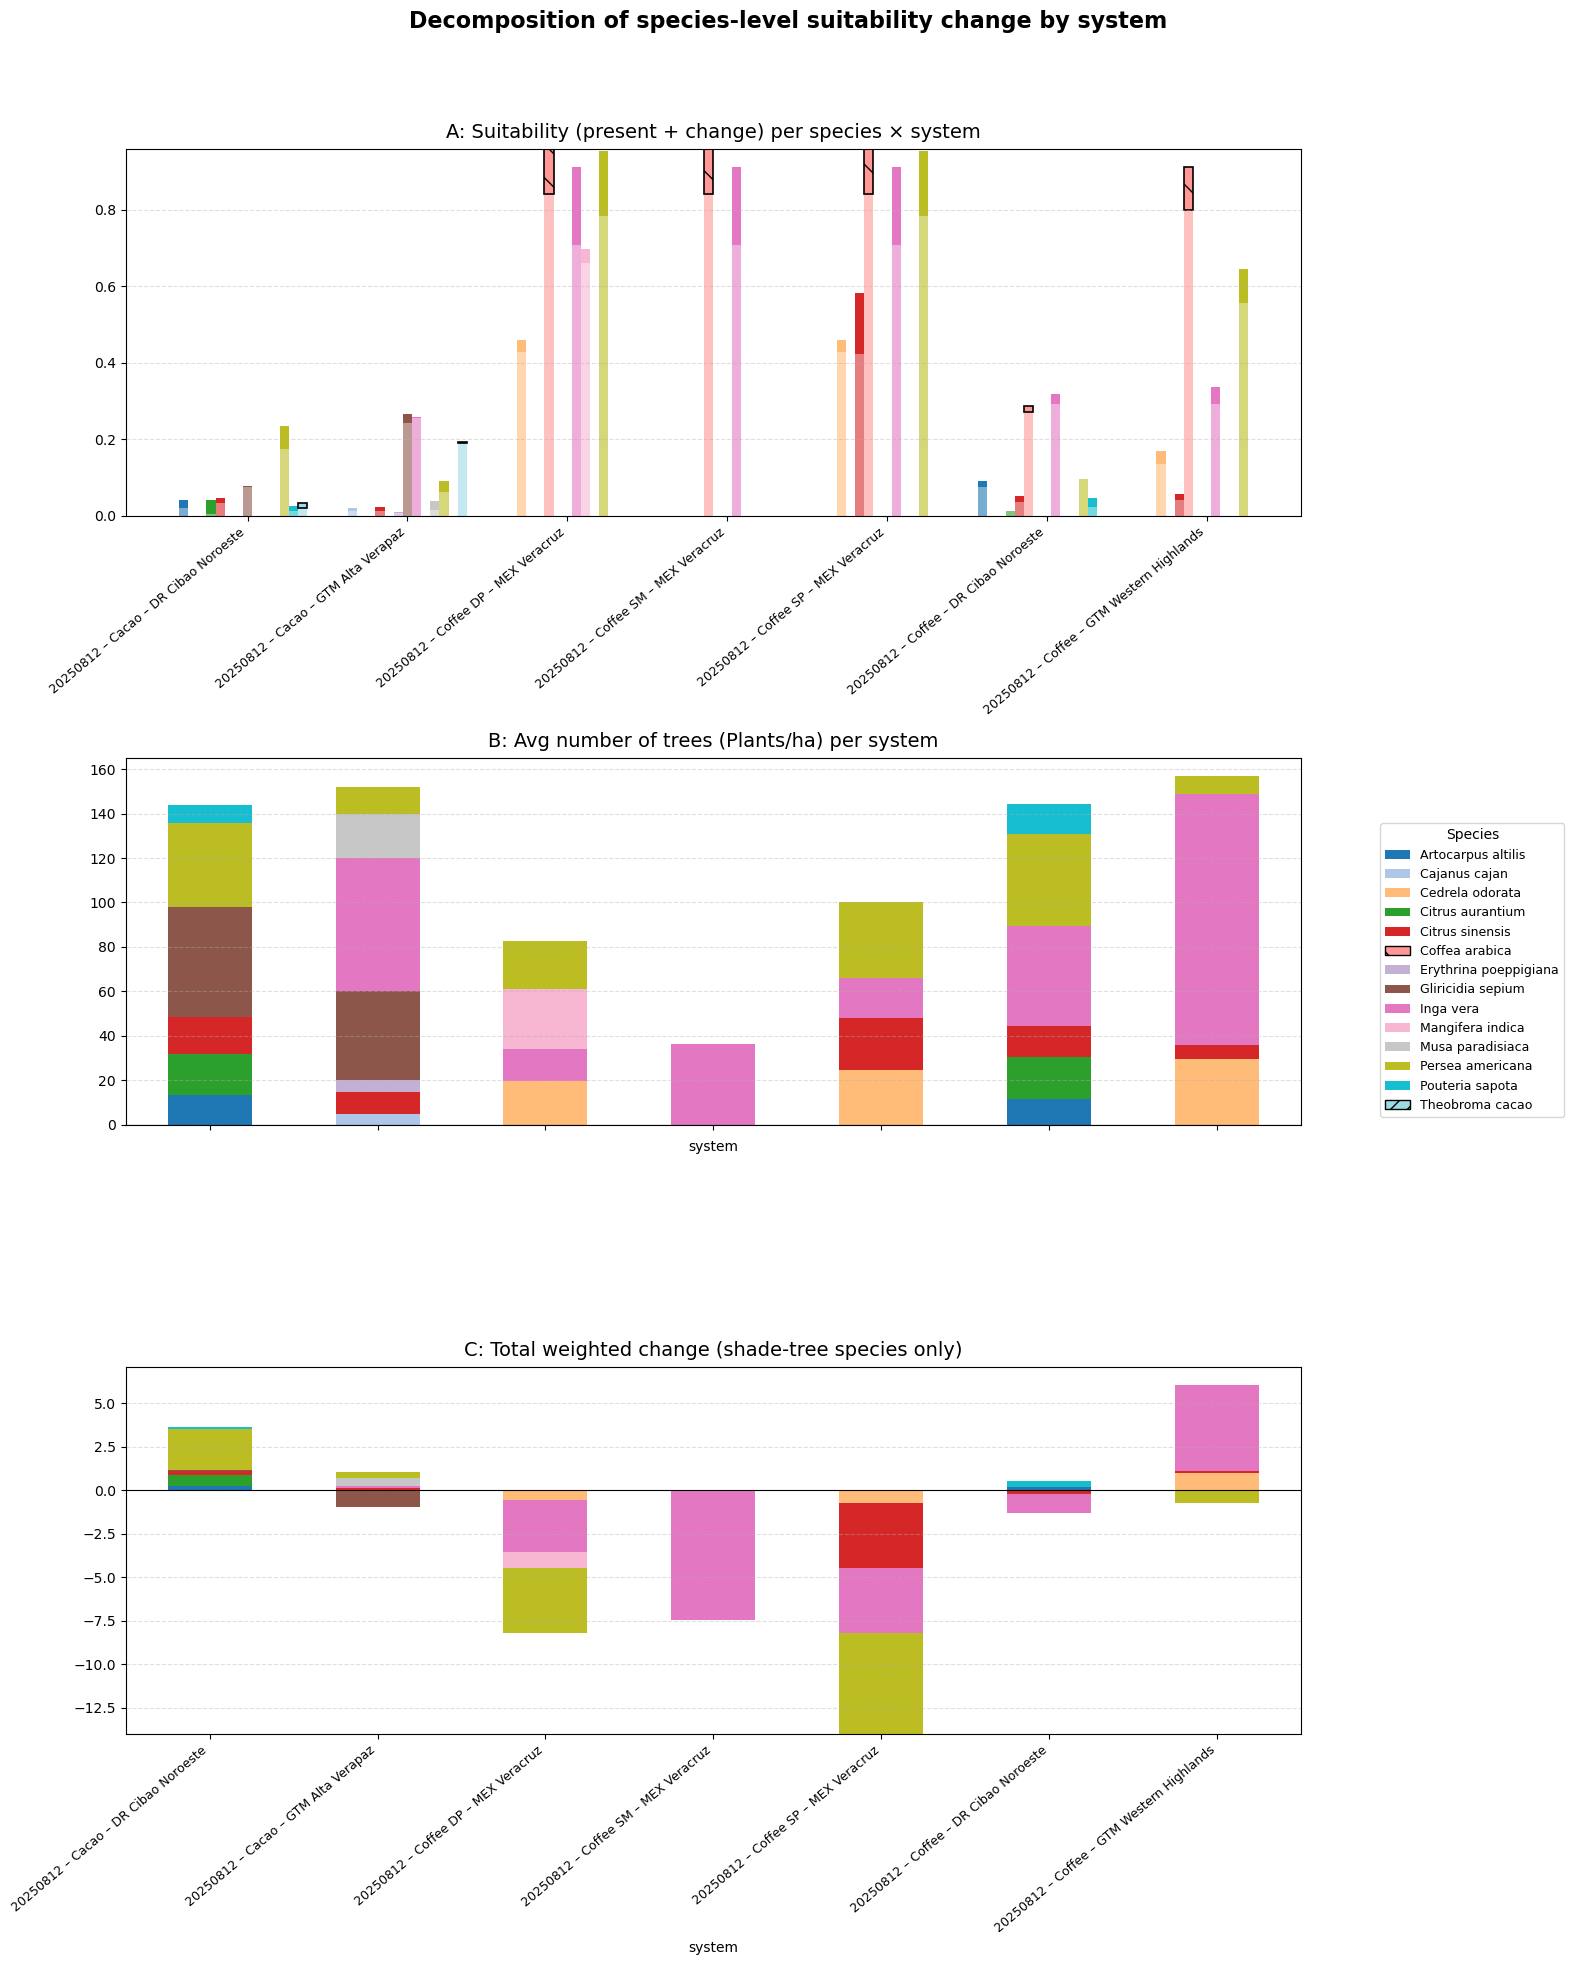

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# =========================
# 1) REBUILD LONG TABLE
# =========================
df_all_systems = pd.concat(
    [gdf.assign(system=sys) for sys, gdf in system_results.items()],
    ignore_index=True
)
df_all_systems["suitability_change"] = (
    df_all_systems["suitability_future"] - df_all_systems["suitability_now"]
)

# =========================
# 2) PANELS' DATA
# =========================
panel_b = (
    df_all_systems
    .groupby(["system", "species_clean"])["Plants/ha"]
    .mean()
    .unstack(fill_value=0)
)

panel_a_species = (
    df_all_systems
    .groupby(["system", "species_clean"])[["suitability_now", "suitability_future"]]
    .mean()
    .assign(Change=lambda d: d["suitability_future"] - d["suitability_now"])
    .reset_index()
)

species_changes = (
    df_all_systems
    .groupby(["system", "species_clean"])[["suitability_now", "suitability_future"]]
    .mean()
    .assign(Change=lambda d: d["suitability_future"] - d["suitability_now"])
    .reset_index()
    .pivot(index="system", columns="species_clean", values="Change")
)
panel_c = panel_b * species_changes

systems_order = panel_b.index.tolist()

# =========================
# 3) LABEL CLEANING
# =========================
def clean_system_label(label: str) -> str:
    mexico_map = {
        "Coffee DP - Mexico Veracruz": "Coffee – Mexico Veracruz (Traditional)",
        "Coffee SM - Mexico Veracruz": "Coffee – Mexico Veracruz (Multi-shade)",
        "Coffee MC - Mexico Veracruz": "Coffee – Mexico Veracruz (Monoculture)",
        "Coffee SP - Mexico Veracruz": "Coffee – Mexico Veracruz (Polyculture)",
    }
    if label in mexico_map:
        return mexico_map[label]
    return label.replace("__", " – ").replace("_", " ")

clean_labels = [clean_system_label(s) for s in systems_order]

# =========================
# 4) COLORS (distinct per species)
# =========================
species_list = panel_b.columns.tolist()
cmap = plt.cm.get_cmap("tab20", len(species_list))
species_colors = {sp: cmap(i) for i, sp in enumerate(species_list)}

# Highlight only the main crops in Panel A
main_crops = {"Coffea arabica": "Coffee", "Theobroma cacao": "Cacao"}

# =========================
# 5) PLOT
# =========================
fig, axes = plt.subplots(3, 1, figsize=(16, 20), sharex=False)
fig.subplots_adjust(hspace=0.6, top=0.9, right=0.8, bottom=0.28)

# --- Panel A (stacked: present + change) ---
systems = systems_order
x = range(len(systems))
bar_width = 0.8 / len(species_list)

for i, sp in enumerate(species_list):
    sub = panel_a_species[panel_a_species["species_clean"] == sp].set_index("system")
    sub = sub.reindex(systems)  # align order
    change = sub["suitability_future"] - sub["suitability_now"]

    # plot 'now' as baseline
    axes[0].bar(
        [pos + i*bar_width for pos in x],
        sub["suitability_now"],
        width=bar_width,
        label=f"{sp} (now)" if i == 0 else None,
        color=species_colors[sp],
        alpha=0.6
    )

    # plot only the difference stacked on top
    axes[0].bar(
        [pos + i*bar_width for pos in x],
        change,
        width=bar_width,
        bottom=sub["suitability_now"],
        label=f"{sp} (change)" if i == 0 else None,
        color=species_colors[sp],
        alpha=1.0,
        edgecolor="black" if sp in main_crops else "none",
        linewidth=1.2 if sp in main_crops else 0.5,
        hatch="//" if sp == "Theobroma cacao" else "\\" if sp == "Coffea arabica" else None
    )

axes[0].set_title("A: Suitability (present + change) per species × system",
                  fontsize=14, pad=8)
axes[0].set_xticks([pos + bar_width*len(species_list)/2 for pos in x])
axes[0].set_xticklabels(clean_labels, rotation=40, ha="right", fontsize=9)
axes[0].grid(axis="y", linestyle="--", alpha=0.4)


# --- Panel B (composition, no shading) ---
panel_b.loc[systems_order, species_list].plot(
    kind="bar", stacked=True, ax=axes[1],
    color=[species_colors[sp] for sp in species_list], legend=False
)
axes[1].set_title("B: Avg number of trees (Plants/ha) per system", fontsize=14, pad=8)
axes[1].axhline(0, color="black", lw=0.8)
axes[1].grid(axis="y", linestyle="--", alpha=0.4)
axes[1].set_xticklabels([])

# --- Panel C (weighted per-species change, no shading) ---
panel_c.loc[systems_order, species_list].plot(
    kind="bar", stacked=True, ax=axes[2],
    color=[species_colors[sp] for sp in species_list], legend=False
)
axes[2].set_title("C: Total weighted change (shade-tree species only)", fontsize=14, pad=8)
axes[2].axhline(0, color="black", lw=0.8)
axes[2].grid(axis="y", linestyle="--", alpha=0.4)
axes[2].set_xticks(range(len(clean_labels)))
axes[2].set_xticklabels(clean_labels, rotation=40, ha="right", fontsize=9)

# --- Legend (species, with main crops hatched) ---
legend_handles = []
for sp in species_list:
    if sp in main_crops:
        hatch = "//" if sp == "Theobroma cacao" else "\\"
        handle = Patch(facecolor=species_colors[sp],
                       edgecolor="black",
                       hatch=hatch,
                       label=sp)
    else:
        handle = Patch(facecolor=species_colors[sp],
                       edgecolor="none",
                       label=sp)
    legend_handles.append(handle)

fig.legend(
    handles=legend_handles,
    labels=species_list,
    title="Species",
    loc="center right",
    bbox_to_anchor=(0.985, 0.5),
    borderaxespad=0.0,
    fontsize=9
)

fig.suptitle("Decomposition of species-level suitability change by system", fontsize=16, weight="bold")

plt.tight_layout(rect=[0, 0, 0.83, 0.95])
plt.show()


In [53]:
df_all_systems.columns

Index(['Plot ID', 'Region', 'System', 'Plot size (ha)', 'Species',
       'Scientific name', 'Plants/ha', 'Yield (t/ha/year)',
       'Per-tree shading (%)', 'Latitude', 'Longitude', 'species_clean',
       'value', 'impf_Artocarpus altilis', 'impf_Cajanus cajan',
       'impf_Cedrela odorata', 'impf_Chamedorea tepejilote',
       'impf_Citrus aurantium', 'impf_Citrus sinensis', 'impf_Coffea arabica',
       'impf_Enterolobium cyclocarpum', 'impf_Erythrina poeppigiana',
       'impf_Gliricidia sepium', 'impf_Inga vera', 'impf_Juglans spp.',
       'impf_Mangifera indica', 'impf_Mimosa scabrella', 'impf_Musa acuminata',
       'impf_Musa paradisiaca', 'impf_Persea americana',
       'impf_Pouteria sapota', 'impf_Quercus sapotifolia',
       'impf_Spondias mombins', 'impf_Theobroma cacao', 'geometry',
       'centr_Theobroma cacao', 'centr_Gliricidia sepium',
       'centr_Citrus aurantium', 'centr_Citrus sinensis',
       'centr_Pouteria sapota', 'centr_Artocarpus altilis',
       'cent

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_23948/3785875168.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


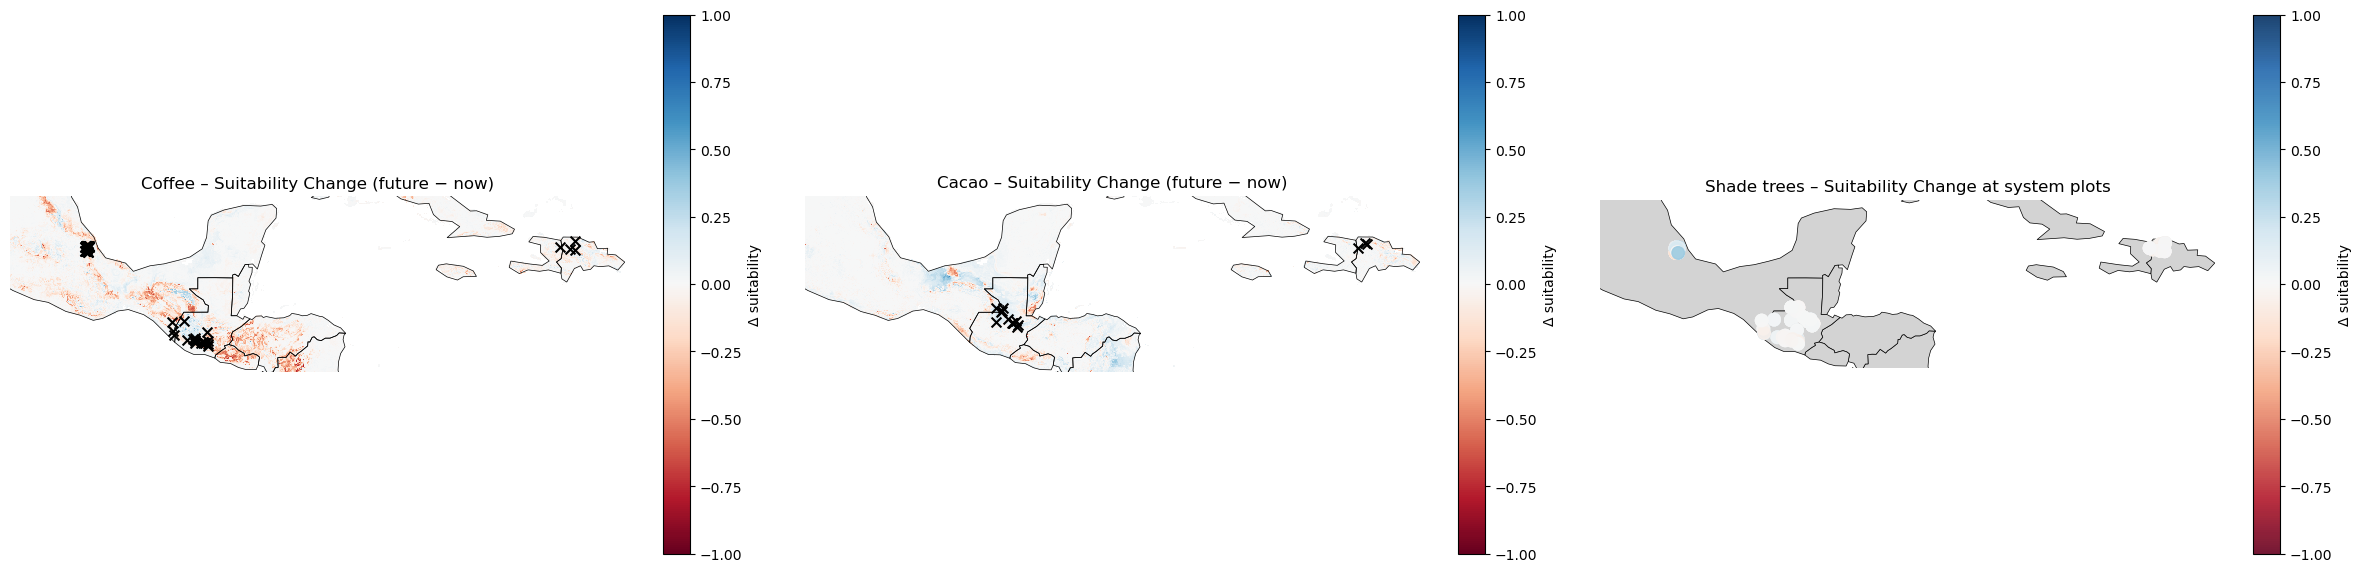

In [105]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# =========================
# 1) Borders (DR, GTM, MEX)
# =========================
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
focus_countries = ["Dominican Republic", "Guatemala", "Mexico"]
borders = world.to_crs("EPSG:4326")

# =========================
# 2) Plot points
# =========================
plot_points = gpd.GeoDataFrame(df_all_systems, geometry=df_all_systems.geometry, crs="EPSG:4326")

main_crops = ["Coffea arabica", "Theobroma cacao"]
shade_points = plot_points[~plot_points["species_clean"].isin(main_crops)]
coffee_points = plot_points[plot_points["species_clean"] == "Coffea arabica"]
cacao_points = plot_points[plot_points["species_clean"] == "Theobroma cacao"]

# =========================
# 3) Function to build change grid directly
# =========================
def build_change_grid(species, now_maps, future_maps):
    df_now = now_maps[species]
    df_future = future_maps[species]

    df_merge = df_now.merge(df_future, on=["lat","lon"], suffixes=("_now","_future"))
    df_merge["change"] = df_merge["suitability_future"] - df_merge["suitability_now"]

    lons = np.sort(df_merge["lon"].unique())
    lats = np.sort(df_merge["lat"].unique())[::-1]
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    Z = np.full(lon_grid.shape, np.nan, dtype=np.float32)

    for _, row in df_merge.iterrows():
        i = np.where(lats == row["lat"])[0][0]
        j = np.where(lons == row["lon"])[0][0]
        Z[i, j] = row["change"]

    return lon_grid, lat_grid, Z

# Build grids
lon_c, lat_c, coffee_change = build_change_grid("Coffea arabica", suitability_maps_now, suitability_maps_future)
lon_k, lat_k, cacao_change = build_change_grid("Theobroma cacao", suitability_maps_now, suitability_maps_future)

extent_coffee = [lon_c.min(), lon_c.max(), lat_c.min(), lat_c.max()]
extent_cacao  = [lon_k.min(), lon_k.max(), lat_k.min(), lat_k.max()]

# =========================
# 4) Plot maps
# =========================
cmap = "RdBu"

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# --- Coffee map ---
im1 = axes[0].pcolormesh(lon_c, lat_c, coffee_change, cmap=cmap, vmin=-1, vmax=1)
borders.plot(ax=axes[0], color="none", edgecolor="black", linewidth=0.5)
coffee_points.plot(ax=axes[0], color="black", marker="x", markersize=50)
axes[0].set_xlim(extent_coffee[0], extent_coffee[1])
axes[0].set_ylim(extent_coffee[2], extent_coffee[3])
axes[0].set_title("Coffee – Suitability Change (future − now)")
axes[0].set_axis_off()
fig.colorbar(im1, ax=axes[0], shrink=0.7, label="Δ suitability")

# --- Cacao map ---
im2 = axes[1].pcolormesh(lon_k, lat_k, cacao_change, cmap=cmap, vmin=-1, vmax=1)
borders.plot(ax=axes[1], color="none", edgecolor="black", linewidth=0.5)
cacao_points.plot(ax=axes[1], color="black", marker="x", markersize=50)
axes[1].set_xlim(extent_cacao[0], extent_cacao[1])
axes[1].set_ylim(extent_cacao[2], extent_cacao[3])
axes[1].set_title("Cacao – Suitability Change (future − now)")
axes[1].set_axis_off()
fig.colorbar(im2, ax=axes[1], shrink=0.7, label="Δ suitability")

# --- Shade trees map ---
borders.plot(ax=axes[2], color="lightgrey", edgecolor="black", linewidth=0.5)
sc = axes[2].scatter(
    shade_points.geometry.x, shade_points.geometry.y,
    c=shade_points["suitability_change"], cmap=cmap,
    vmin=-1, vmax=1, s=80, alpha=0.9
)
axes[2].set_xlim(min(extent_coffee[0], extent_cacao[0]), max(extent_coffee[1], extent_cacao[1]))
axes[2].set_ylim(min(extent_coffee[2], extent_cacao[2]), max(extent_coffee[3], extent_cacao[3]))
axes[2].set_title("Shade trees – Suitability Change at system plots")
axes[2].set_axis_off()
fig.colorbar(sc, ax=axes[2], shrink=0.7, label="Δ suitability")

plt.tight_layout()
plt.show()


# Let's now also model risks from extreme events

### for now we look just at drought and tropical cyclones, but you could also look at high temepratures and low precipitations

In [132]:
import pandas as pd
from config import ECOCROP_PATH

# Load EcoCrop database
ecocrop = pd.read_csv(ECOCROP_PATH, encoding="latin1")

# Clean EcoCrop species names
ecocrop["species"] = ecocrop["ScientificName"].str.strip().str.lower()

# Select relevant climate and drought-related columns
climate_cols = [
    "species",
    "TMIN", "TOPMN", "TOPMX", "TMAX",
    "RMIN", "ROPMN", "ROPMX", "RMAX",
    "PHOTO", "KTMPR", "KTMP", "CLIZ",
    "DRA", "DRAR"
]
ecocrop_subset = ecocrop[climate_cols]

for exp in exposures_present:
    # Clean and match with agroforest_df
    agroforest_df = exposures_present[exp].gdf
    agroforest_df["species"] = agroforest_df["species_clean"].str.strip().str.lower()
    agroforest_df = agroforest_df.merge(ecocrop_subset, on="species", how="left")

    exposures_present[exp] = Exposures(agroforest_df)

In [136]:
agroforest_df.DRA.unique()

array(['well (dry spells)', nan], dtype=object)

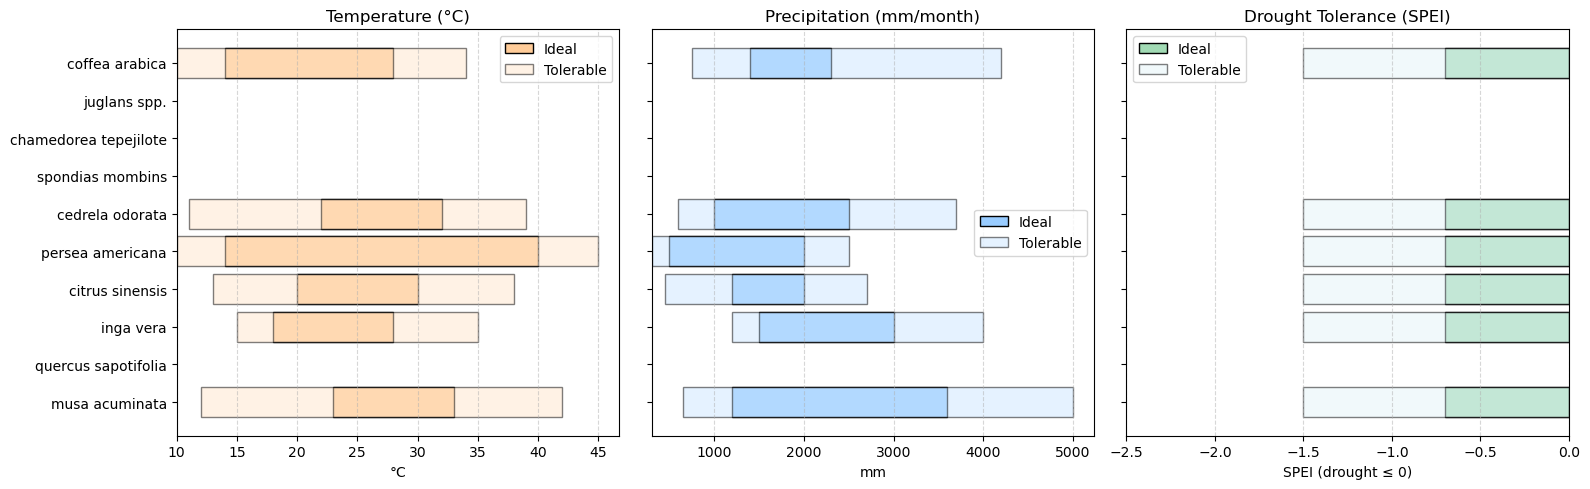

In [133]:
from utils_agroforestry import *

spei_dict = generate_spei_dict_from_dra(agroforest_df)
plot_agroforest_vulnerability(agroforest_df, spei_dict)



In [138]:
agroforest_df

,Plot ID,Region,System,Plot size (ha),Species,Scientific name,Plants/ha,Yield (t/ha/year),Per-tree shading (%),Latitude,...,RMIN,ROPMN,ROPMX,RMAX,PHOTO,KTMPR,KTMP,CLIZ,DRA,DRAR
0,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Coffee (main crop),Coffea arabica,NaN,0.78,NaN,14.542375,...,750.0,1400.0,2300.0,4200.0,"short day (<12 hours), neutral day (12-14 hours)",NaN,NaN,"tropical wet & dry (Aw), subtropical humid (Cf...",well (dry spells),well (dry spells)
1,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Guama,Inga spp.,94.0,NaN,51.7,14.542375,...,1200.0,1500.0,3000.0,4000.0,NaN,NaN,NaN,"tropical wet & dry (Aw), tropical wet (Ar)",well (dry spells),well (dry spells)
2,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Cedar,Cedrela odorata,25.0,NaN,33.9,14.542375,...,600.0,1000.0,2500.0,3700.0,short day (<12 hours),NaN,NaN,"tropical wet & dry (Aw), tropical wet (Ar)",well (dry spells),well (dry spells)
3,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Oak,Quercus spp.,17.0,NaN,36.0,14.542375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GTM_Coffee_WH_001,GTM - Western Highlands,Coffee,3.5,Walnut,Juglans spp.,13.0,NaN,39.0,14.542375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,GTM_Coffee_WH_020,GTM - Western Highlands,Coffee,3.5,Walnut,Juglans spp.,12.0,NaN,35.5,14.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,GTM_Coffee_WH_020,GTM - Western Highlands,Coffee,3.5,Avocado,Persea americana,7.0,NaN,36.8,14.500000,...,300.0,500.0,2000.0,2500.0,NaN,-4.0,-1.0,"tropical wet & dry (Aw), tropical wet (Ar)",well (dry spells),well (dry spells)
187,GTM_Coffee_WH_020,GTM - Western Highlands,Coffee,3.5,Citrus,Citrus spp.,5.0,NaN,36.9,14.500000,...,450.0,1200.0,2000.0,2700.0,"short day (<12 hours), neutral day (12-14 hour...",-10.0,0.0,"tropical wet & dry (Aw), tropical wet (Ar), st...",well (dry spells),well (dry spells)
188,GTM_Coffee_WH_020,GTM - Western Highlands,Coffee,3.5,Pacaya,Chamedorea spp.,4.0,NaN,25.2,14.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### we are only interested in drought for now. let's just assume a standard vulnerability, all species or similarly vulnerable

In [142]:
import os
from config import bbox
from climada.hazard.base import Hazard
from config import DATA_DIR, TERRACLIMATE_PATHS
from utils_hazards import (
    get_aggregates, compute_spei_3,
    generate_gev_sample_field, create_hazard_from_array
)

# === Settings ===
LON_BOUNDS_DR = (bbox[0], bbox[2])        # (west, east)
LAT_BOUNDS_DR = (bbox[3], bbox[1])        # (north, south)
TERRACLIMATE_PATHS = {
    "plus2C": DATA_DIR / "terra_climate_scenarios_ncss/plus2C",
        "plus4C": DATA_DIR / "terra_climate_scenarios_ncss/plus4C",

    "historical":  DATA_DIR / "terra_climate"
}

haz_types = ["SPEI"]
output_dir = os.path.join(DATA_DIR, "hazards")
os.makedirs(output_dir, exist_ok=True)

def get_hazard_path(scenario, haz_type):
    return os.path.join(output_dir, f"write_hazard_{scenario}_{haz_type}.hdf5")

def load_hazard_from_file(scenario, haz_type):
    path = get_hazard_path(scenario, haz_type)
    haz = Hazard.from_hdf5(path)
    print(f"📂 Loaded: {path}")
    return haz

def save_hazard_to_file(hazard, scenario, haz_type):
    path = get_hazard_path(scenario, haz_type)
    hazard.write_hdf5(path)
    print(f"💾 Saved: {path}")

# === Main loop ===
hazard_dict = {}

for scenario, path in TERRACLIMATE_PATHS.items():
    print(f"\n🚀 Processing scenario: {scenario}")
    all_exist = all(os.path.exists(get_hazard_path(scenario, haz_type)) for haz_type in haz_types)

    if all_exist:
        print("✅ All hazard files found — skipping computation.")
        hazard_dict[scenario] = {
            haz_type: load_hazard_from_file(scenario, haz_type)
            for haz_type in haz_types
        }
        continue

    print("🧮 Computing hazards...")
    tmean, ppt, ppt_monthly, pet_monthly = get_aggregates(path)
    # Mask invalid cells in both arrays
    mask_invalid = np.isnan(ppt_monthly) | np.isnan(pet_monthly)
    ppt_monthly = ppt_monthly.where(~mask_invalid)
    pet_monthly = pet_monthly.where(~mask_invalid)
    print("🌵 Computing SPEI...")
    spei_3 = compute_spei_3(ppt_monthly, pet_monthly)
    spei_yearly = spei_3.groupby(spei_3.time.dt.year).min("time")

    print("🎲 Sampling synthetic HOT, DRY, and DRIEST years (GEV)...")
    #tmean_100yrs = generate_gev_sample_field(tmean, n_years=100)
    #ppt_100yrs = generate_gev_sample_field(ppt, n_years=100, invert=True)
    spei_100yrs = generate_gev_sample_field(spei_yearly, n_years=100, invert=True)

    print("🌍 Creating CLIMADA Hazard objects...")
    # haz_tmean = create_hazard_from_array(tmean_100yrs, haz_type="TM", units="degC")
    # haz_ppt = create_hazard_from_array(ppt_100yrs, haz_type="PR", units="mm")
    haz_spei = create_hazard_from_array(spei_100yrs, haz_type="SPEI", units="index")

    # Save to disk
    # save_hazard_to_file(haz_tmean, scenario, "TM")
    # save_hazard_to_file(haz_ppt, scenario, "PR")
    save_hazard_to_file(haz_spei, scenario, "SPEI")

    hazard_dict[scenario] = {
        # "TM": haz_tmean,
        # "PR": haz_ppt,
        "SPEI": haz_spei
    }



🚀 Processing scenario: plus2C
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus2C_SPEI.hdf5

🚀 Processing scenario: plus4C
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus4C_SPEI.hdf5

🚀 Processing scenario: historical
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_historical_SPEI.hdf5


<GeoAxes: title={'center': 'SPEI max intensity at each point'}>

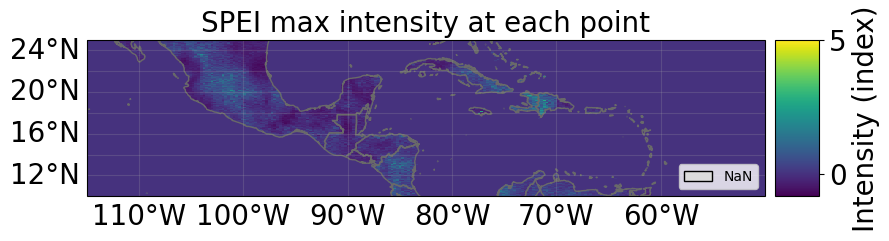

In [17]:
haz_spei.plot_intensity(0, vmax=5)

In [24]:
TERRACLIMATE_PATHS.items()

dict_items([('plus2C', PosixPath('/Users/szelie/data/biofincas/terra_climate_scenarios_ncss/plus2C')), ('plus4C', PosixPath('/Users/szelie/data/biofincas/terra_climate_scenarios_ncss/plus4C')), ('historical', PosixPath('/Users/szelie/data/biofincas/terra_climate'))])

### let's also load tropical cyclone for the north atlantic basin

In [26]:
from climada.util.api_client import Client
from climada.hazard import Hazard

client = Client()

# --- HISTORICAL ---
tc_hist_na = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "NA", "event_type": "synthetic", "climate_scenario": "None"}
)
tc_hist_ep = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "EP", "event_type": "synthetic", "climate_scenario": "None"}
)

tc_hist_all = Hazard.concat([tc_hist_na, tc_hist_ep])

# --- FUTURE (2°C / RCP4.5 around 2060) ---
tc_future_na = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "NA", "event_type": "synthetic", "climate_scenario": "rcp45", "ref_year": "2060"}
)
tc_future_ep = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "EP", "event_type": "synthetic", "climate_scenario": "rcp45", "ref_year": "2060"}
)

tc_future_all = Hazard.concat([tc_future_na, tc_future_ep])

# --- Add to your hazard dictionary ---
hazard_dict['historical']["TC"] = tc_hist_all
hazard_dict["plus2C"]["TC"] = tc_future_all


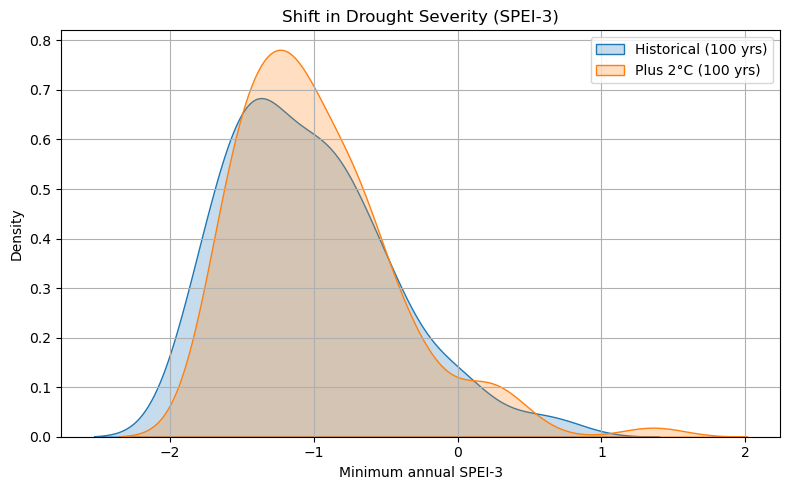

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the location
lat = 19.293583
lon = -71.252111

# Helper to extract intensity at the nearest point
def get_intensity_at_point(hazard, lat, lon):
    dists = np.sqrt((hazard.centroids.lat - lat)**2 + (hazard.centroids.lon - lon)**2)
    idx = dists.argmin()
    return hazard.intensity.toarray()[:, idx]

# Extract values
spei_hist = get_intensity_at_point(hazard_dict["historical"]["SPEI"], lat, lon)
spei_2c   = get_intensity_at_point(hazard_dict["plus2C"]["SPEI"], lat, lon)
#spei_4c   = get_intensity_at_point(hazard_dict["plus4C"]["SPEI"], lat, lon)

# Plot helper (multi-scenario)
def plot_kde_multi(data_dict, xlabel, title):
    plt.figure(figsize=(8, 5))
    for label, values in data_dict.items():
        sns.kdeplot(values, label=label, fill=True)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot SPEI comparison
plot_kde_multi(
    {
        "Historical (100 yrs)": spei_hist,
        "Plus 2°C (100 yrs)": spei_2c,
       # "Plus 4°C (100 yrs)": spei_4c,
    },
    xlabel="Minimum annual SPEI-3",
    title="Shift in Drought Severity (SPEI-3)"
)


### Impact function definitions

The cells below define **impact functions (IMPFs)** for different hazards affecting perennial crops (coffee, cacao):

- **Temperature & Precipitation**  
  Species-specific trapezoidal functions based on optimal and tolerance ranges.  
  If thresholds are missing, fallback curves are derived from the local mean climate.

- **Tropical Cyclones (TC)**  
  Wind–damage curves for high, medium, and low canopy vulnerability classes, plus a default no-impact case.

- **Drought (DR)**  
  Impact functions based on species’ tolerance ranges in SPEI. Includes a generic fallback drought curve.

Finally, a helper links each crop species in the exposure dataframe to the appropriate impact function IDs (TM, PR, DR, TC).


### Impact function definitions

The cells below define **impact functions (IMPFs)** for different hazards affecting perennial crops (coffee, cacao):

- **Temperature & Precipitation**  
  Species-specific trapezoidal functions based on optimal and tolerance ranges.  
  If thresholds are missing, fallback curves are derived from the local mean climate.

- **Tropical Cyclones (TC)**  
  Wind–damage curves for high, medium, and low canopy vulnerability classes, plus a default no-impact case.

- **Drought (DR)**  
  Impact functions based on species’ tolerance ranges in SPEI. Includes a generic fallback drought curve.

Finally, a helper links each crop species in the exposure dataframe to the appropriate impact function IDs (TM, PR, DR, TC).


In [175]:
def get_climate_at_point(tmean, ppt, lat, lon):
    t = tmean.sel(lat=lat, lon=lon, method="nearest").mean("year").values.item()
    p = ppt.sel(lat=lat, lon=lon, method="nearest").mean("year").values.item()
    return t, p

# === Per-hazard definitions ===
def make_trapezoidal_impact_func(haz_type, name, min_val, opt_min, opt_max, max_val, id_):
    impf = ImpactFunc()
    impf.haz_type = haz_type
    impf.id = id_
    impf.name = name

    if haz_type == "TM":
        intensity = np.array([opt_max, max_val, max_val + 5, max_val + 10])
        mdd = np.array([0.0, 0.5, 0.8, 1.0])
    elif haz_type == "PR":
        intensity = np.array([min_val - 500, min_val - 200, opt_min, opt_min + 1])
        mdd = np.array([1.0, 0.8, 0.3, 0.0])

    impf.intensity = intensity
    impf.mdd = mdd
    impf.paa = np.ones_like(mdd)
    impf.mdr = impf.mdd * impf.paa

    impf.check()
    return impf

# === Tropical cyclone impact functions ===
def define_tc_impfs():
    impf_set = ImpactFuncSet()
    intensity = np.linspace(0, 100, 15)

    def make_tc_curve(i, label, power):
        return ImpactFunc(
            haz_type="TC",
            id=i,
            name=label,
            intensity=intensity,
            mdd=np.linspace(0, 1, 15)**power,
            paa=np.ones(15),
        )

    impf_set.append(make_tc_curve(1, "High vulnerability (tall + dense canopy)", 1.5))
    impf_set.append(make_tc_curve(2, "Medium vulnerability (moderate canopy)", 2))
    impf_set.append(make_tc_curve(3, "Low vulnerability (short/sparse canopy)", 3))
    impf_set.append(
        ImpactFunc(
            haz_type="TC",
            id=0,
            name="Unknown / default",
            intensity=intensity,
            mdd=np.zeros(15),
            paa=np.zeros(15),
        )
    )
    return impf_set


# === Drought impact functions ===
def define_drought_impfs(spei_dict):
    impf_set = ImpactFuncSet()
    species_to_drought_id = {}

    # Default drought impact function
    default_intensity = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])
    default_mdd = np.array([0.0, 0.0, 0.0, 0.2, 0.4, 0.6])

    default_impf = ImpactFunc(
        haz_type="DR",
        id=0,
        name="Default drought response",
        intensity=default_intensity,
        mdd=default_mdd,
        paa=np.ones_like(default_mdd),
    )
    default_impf.mdr = default_impf.mdd * default_impf.paa
    default_impf.check()
    impf_set.append(default_impf)

    counter = 1
    for species, spei_range in spei_dict.items():
        ideal_min, ideal_max = spei_range["ideal"]
        tol_min, tol_max = spei_range["tolerable"]

        # Convert SPEI to positive intensity values
        spei_vals = [0.0, 0.5, 1.0, abs(ideal_min), abs(tol_min), abs(tol_min + 0.5)]
        intensity = np.array(sorted(set([round(abs(v), 2) for v in spei_vals if v <= 2.5])))

        # Match MDD: zero impact until intensity 1.0, then increase
        mdd = np.piecewise(
            intensity,
            [intensity <= 1.0,
             (intensity > 1.0) & (intensity <= 1.5),
             (intensity > 1.5) & (intensity <= 2.0),
             intensity > 2.0],
            [0.0, 0.2, 0.4, 0.6],
        )

        impf = ImpactFunc(
            haz_type="DR",
            id=counter,
            name=f"Drought tolerance - {species}",
            intensity=intensity,
            mdd=mdd,
            paa=np.ones_like(mdd),
        )
        impf.mdr = impf.mdd * impf.paa
        impf.check()

        impf_set.append(impf)
        species_to_drought_id[species] = counter
        counter += 1

    return impf_set, species_to_drought_id


# === Assign IMPF IDs for TC and drought ===
def assign_impact_function_ids(df, species_to_drought_id=None):
    # Use species_clean (already in your df) instead of 'species'
    if species_to_drought_id:
        df["impf_DR"] = df["species_clean"].map(species_to_drought_id).fillna(0).astype(int)

    def assign_tc(row):
        h = row["canopy_height"]
        f = row["forest_cover"]

        if pd.isnull(h):
            return 0  # default / unknown
        if h >= 15 and f >= 0.5:
            return 1  # High vulnerability
        elif h >= 5:
            return 2  # Medium vulnerability
        else:
            return 3  # Low vulnerability

    df["impf_TC"] = df.apply(assign_tc, axis=1)
    return df




In [179]:
import copy
from climada.engine import ImpactCalc
from climada.entity import Exposures, ImpactFuncSet

# === STEP 1: Add satellite features (adds canopy_height & forest_cover) ===
agroforest_df = apply_satellite_features_to_geodf(agroforest_df)
agroforest_df = agroforest_df.loc[:, ~agroforest_df.columns.duplicated()]

# === STEP 2: Define wind (TC) impact functions ===
impf_set_tc = define_tc_impfs()

# === STEP 3: Define drought (SPEI) impact functions ===
spei_dict = generate_spei_dict_from_dra(agroforest_df)
impf_set_drought, species_to_drought_id = define_drought_impfs(spei_dict)

# === STEP 4: Assign impact function IDs to exposure data ===
agroforest_df = assign_impact_function_ids(
    agroforest_df,
    species_to_drought_id=species_to_drought_id
)


✅ Extracted from: ETH_GlobalCanopyHeight_10m_2020_N12W093_Map.tif, mean: 33.16
✅ Extracted from: 20N_100W.tif, mean: 100.00
✅ Extracted from: ETH_GlobalCanopyHeight_10m_2020_N12W093_Map.tif, mean: 33.16
✅ Extracted from: 20N_100W.tif, mean: 100.00
✅ Extracted from: ETH_GlobalCanopyHeight_10m_2020_N12W093_Map.tif, mean: 33.16
✅ Extracted from: 20N_100W.tif, mean: 100.00
✅ Extracted from: ETH_GlobalCanopyHeight_10m_2020_N12W093_Map.tif, mean: 33.16
✅ Extracted from: 20N_100W.tif, mean: 100.00
✅ Extracted from: ETH_GlobalCanopyHeight_10m_2020_N12W093_Map.tif, mean: 33.16
✅ Extracted from: 20N_100W.tif, mean: 100.00
✅ Extracted from: ETH_GlobalCanopyHeight_10m_2020_N12W093_Map.tif, mean: 33.16
✅ Extracted from: 20N_100W.tif, mean: 100.00
✅ Extracted from: ETH_GlobalCanopyHeight_10m_2020_N12W093_Map.tif, mean: 33.16
✅ Extracted from: 20N_100W.tif, mean: 100.00
✅ Extracted from: ETH_GlobalCanopyHeight_10m_2020_N12W093_Map.tif, mean: 33.16
✅ Extracted from: 20N_100W.tif, mean: 100.00
✅ Extrac

In [181]:
# === STEP 5: Merge all impact functions into a single ImpactFuncSet
impf_set = ImpactFuncSet()

for sub_set in [impf_set_tc, impf_set_drought]:
    for haz_funcs in sub_set.get_func().values():  # haz_funcs = {id: ImpactFunc, ...}
        for impf in haz_funcs.values():
            impf_set.append(copy.deepcopy(impf))


2025-08-18 15:46:20,607 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2025-08-18 15:46:20,609 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


In [182]:
for scenario in hazard_dict:
    hazard_dict[scenario]['SPEI'].intensity = -hazard_dict[scenario]['SPEI'].intensity #climada struggles with negative hazard values
    for haz in hazard_dict[scenario]:
        hazard_dict[scenario][haz].event_id = np.array(hazard_dict[scenario][haz].event_id)

In [183]:
from climada.engine import ImpactCalc
from climada.entity import Exposures

# Output dict: exposure_name -> scenario -> hazard
impact_results = {}

for exp_name, exp in exposures_present.items():
    print(f"🌱 Processing exposure: {exp_name}")
    impact_results[exp_name] = {}
    
    for scenario, hazards in hazard_dict.items():
        impact_results[exp_name][scenario] = {}
        
        for haz_type, hazard in hazards.items():
            print(f"🔧 Computing impact for {exp_name} | {scenario} - {haz_type}")
            
            # Rename drought hazard to DR
            if haz_type == "SPEI":
                hazard.haz_type = "DR"
            
            # Compute impact
            exp.gdf['impf_DR'] = 1
            exp.gdf['impf_TC'] = 1
            impact = ImpactCalc(exp, impf_set, hazard).impact(save_mat=True)
            impact_results[exp_name][scenario][haz_type] = impact


🌱 Processing exposure: 20250812__Cacao__DR_Cibao_Noroeste
🔧 Computing impact for 20250812__Cacao__DR_Cibao_Noroeste | plus2C - SPEI
🔧 Computing impact for 20250812__Cacao__DR_Cibao_Noroeste | plus4C - SPEI
🔧 Computing impact for 20250812__Cacao__DR_Cibao_Noroeste | historical - SPEI
🌱 Processing exposure: 20250812__Cacao__GTM_Alta_Verapaz
🔧 Computing impact for 20250812__Cacao__GTM_Alta_Verapaz | plus2C - SPEI
🔧 Computing impact for 20250812__Cacao__GTM_Alta_Verapaz | plus4C - SPEI
🔧 Computing impact for 20250812__Cacao__GTM_Alta_Verapaz | historical - SPEI
🌱 Processing exposure: 20250812__Coffee_DP__MEX_Veracruz
🔧 Computing impact for 20250812__Coffee_DP__MEX_Veracruz | plus2C - SPEI
🔧 Computing impact for 20250812__Coffee_DP__MEX_Veracruz | plus4C - SPEI
🔧 Computing impact for 20250812__Coffee_DP__MEX_Veracruz | historical - SPEI
🌱 Processing exposure: 20250812__Coffee_SM__MEX_Veracruz
🔧 Computing impact for 20250812__Coffee_SM__MEX_Veracruz | plus2C - SPEI
🔧 Computing impact for 202

In [196]:
hazard_dict

{'plus2C': {'SPEI': <climada.hazard.base.Hazard at 0x36fb8b150>},
 'plus4C': {'SPEI': <climada.hazard.base.Hazard at 0x32a796a90>},
 'historical': {'SPEI': <climada.hazard.base.Hazard at 0x3862fff50>}}

⚠️ Missing data for 20250812__Cacao__DR_Cibao_Noroeste – TC
2025-08-18 15:46:39,675 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


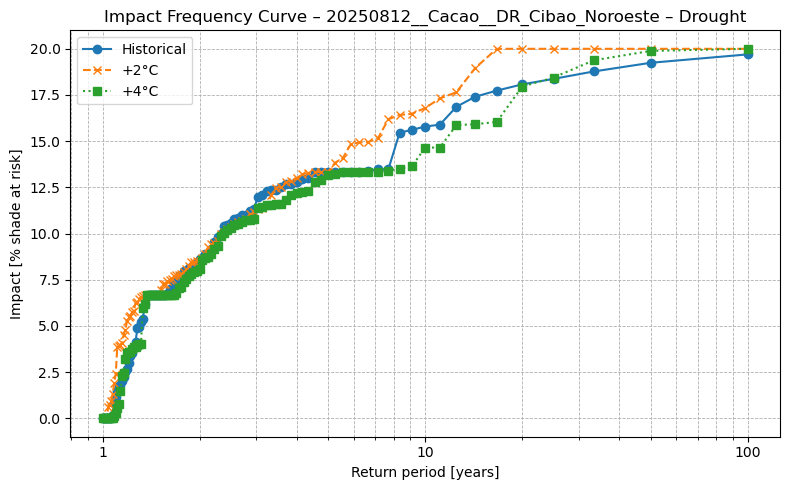

⚠️ Missing data for 20250812__Cacao__GTM_Alta_Verapaz – TC
2025-08-18 15:46:39,866 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


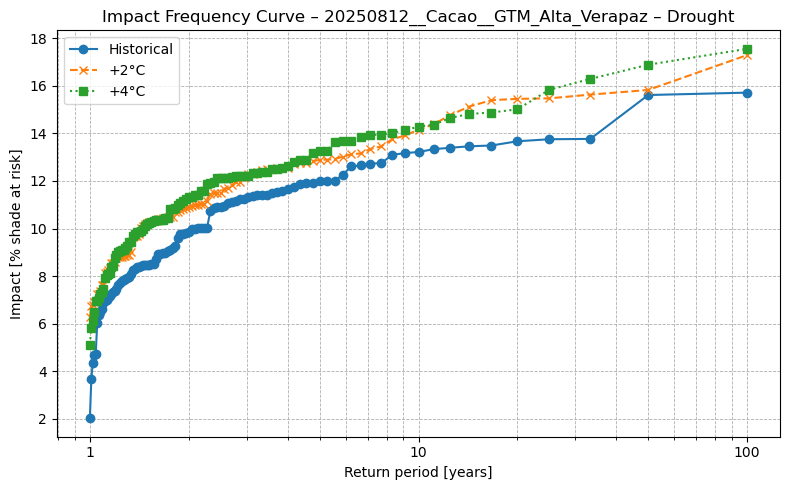

⚠️ Missing data for 20250812__Coffee_DP__MEX_Veracruz – TC
2025-08-18 15:46:39,994 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


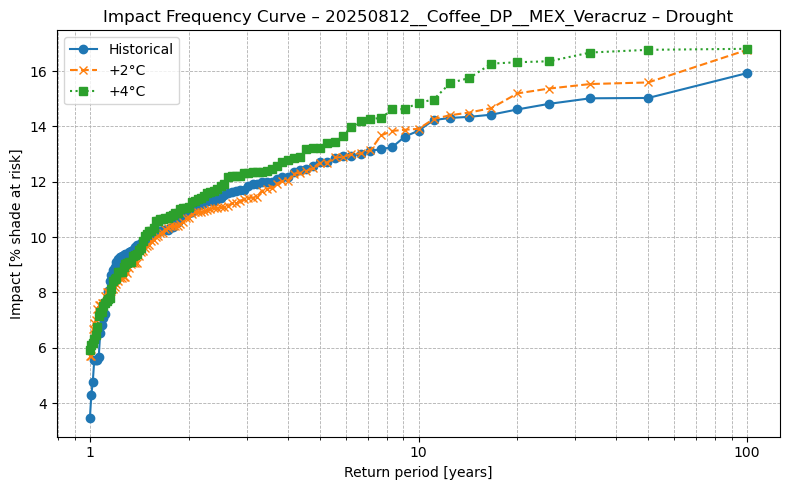

⚠️ Missing data for 20250812__Coffee_SM__MEX_Veracruz – TC
2025-08-18 15:46:40,113 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


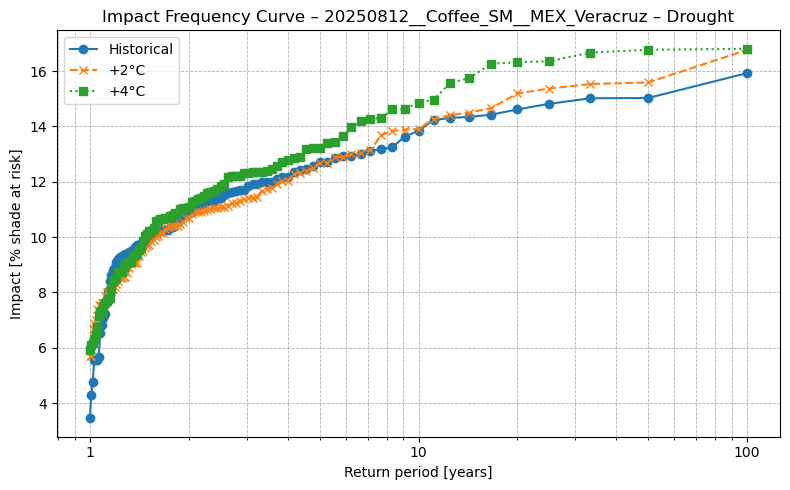

⚠️ Missing data for 20250812__Coffee_SP__MEX_Veracruz – TC
2025-08-18 15:46:40,228 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


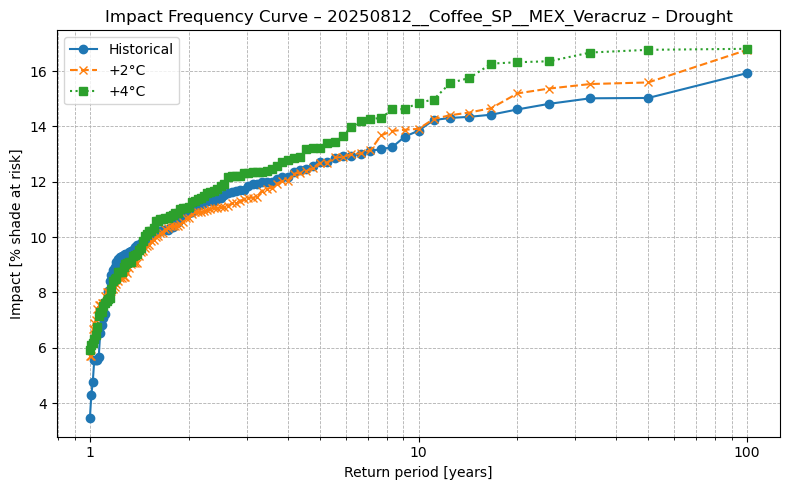

⚠️ Missing data for 20250812__Coffee__DR_Cibao_Noroeste – TC
2025-08-18 15:46:40,347 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


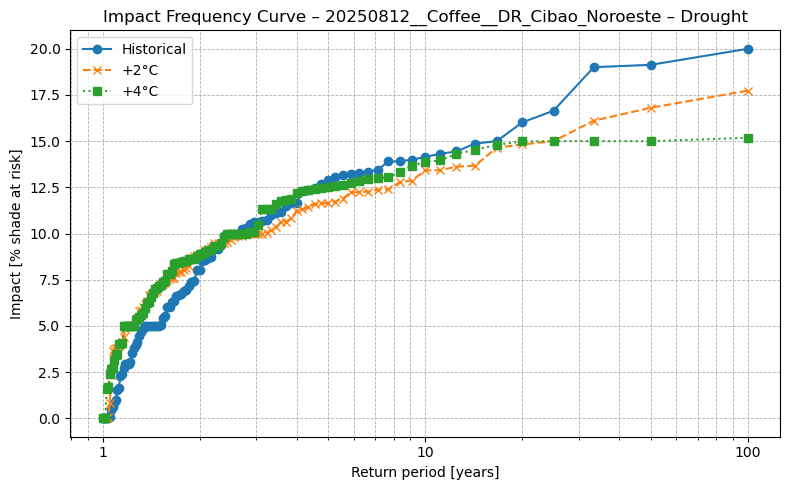

⚠️ Missing data for 20250812__Coffee__GTM_Western_Highlands – TC
2025-08-18 15:46:40,462 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


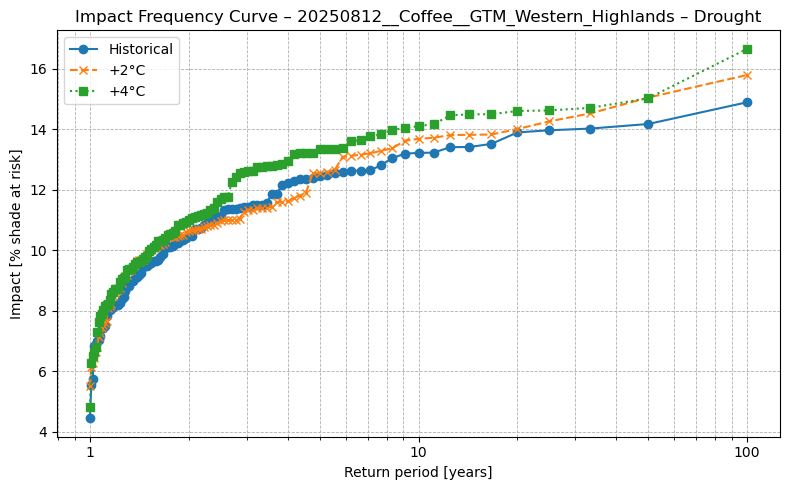

In [184]:
import matplotlib.pyplot as plt

# Hazards you want to plot
hazards_to_plot = {
    "TC": "Tropical Cyclones",
    "SPEI": "Drought"
}

# Loop through your exposures
for exp_name in impact_results.keys():
    for haz_code, haz_label in hazards_to_plot.items():
        try:
            freq_hist = impact_results[exp_name]['historical'][haz_code].calc_freq_curve()
            freq_2C   = impact_results[exp_name]['plus2C'][haz_code].calc_freq_curve()
            freq_4C   = impact_results[exp_name]['plus4C'][haz_code].calc_freq_curve()

            base_tot_value = impact_results[exp_name]['plus2C'][haz_code].tot_value

            plt.figure(figsize=(8, 5))
            plt.plot(freq_hist.return_per,
                     100 * freq_hist.impact / base_tot_value,
                     label="Historical", marker='o', linestyle='-')

            plt.plot(freq_2C.return_per,
                     100 * freq_2C.impact / base_tot_value,
                     label="+2°C", marker='x', linestyle='--')

            plt.plot(freq_4C.return_per,
                     100 * freq_4C.impact / base_tot_value,
                     label="+4°C", marker='s', linestyle=':')

            plt.xlabel("Return period [years]")
            plt.ylabel("Impact [% shade at risk]")
            plt.title(f"Impact Frequency Curve – {exp_name} – {haz_label}")
            plt.legend()
            plt.grid(True, which="both", linestyle='--', linewidth=0.6)
            plt.xscale("log")
            plt.xticks([1, 10, 100], labels=["1", "10", "100"])
            plt.tight_layout()
            plt.show()

        except KeyError:
            print(f"⚠️ Missing data for {exp_name} – {haz_code}")


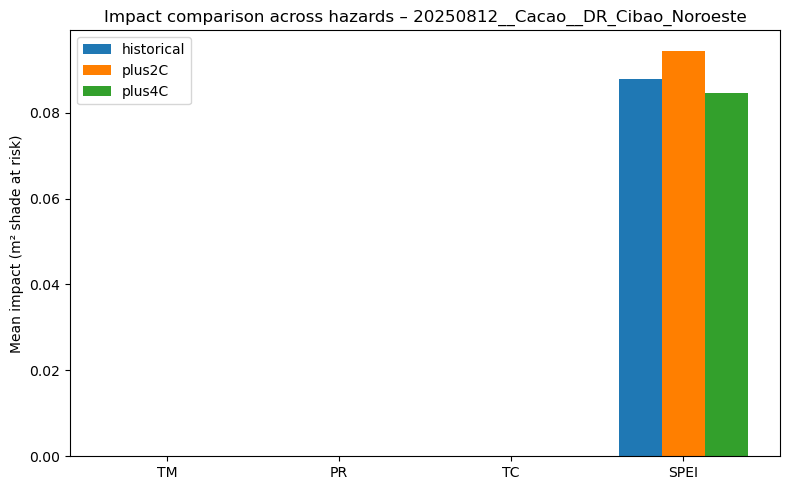

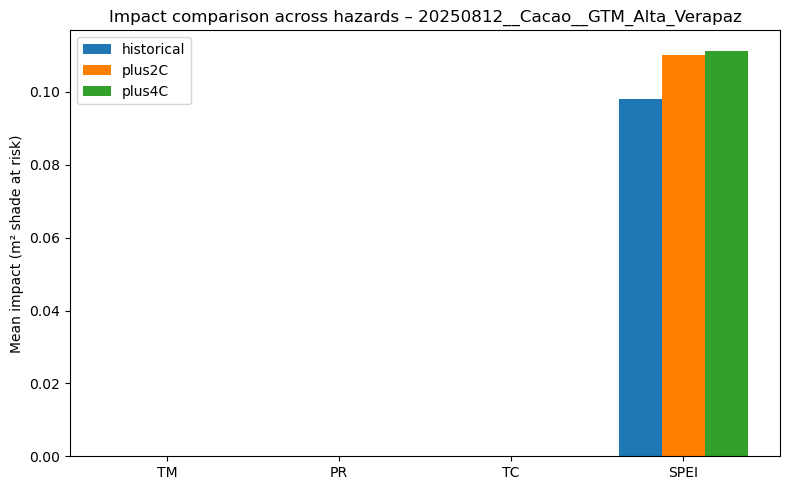

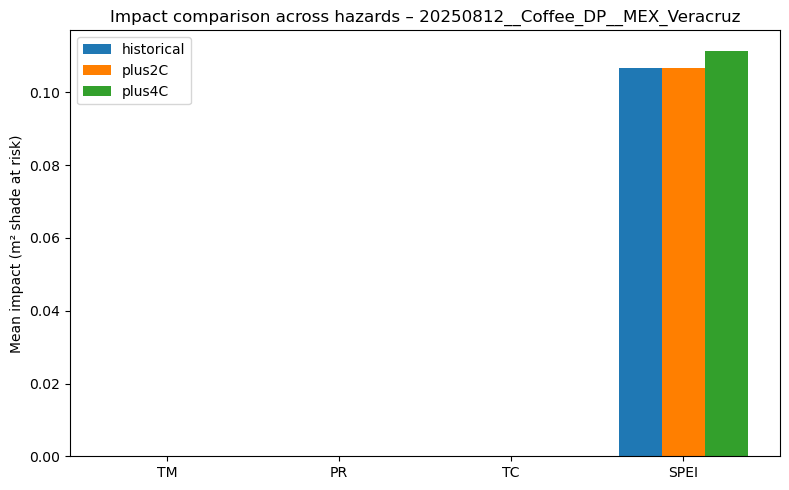

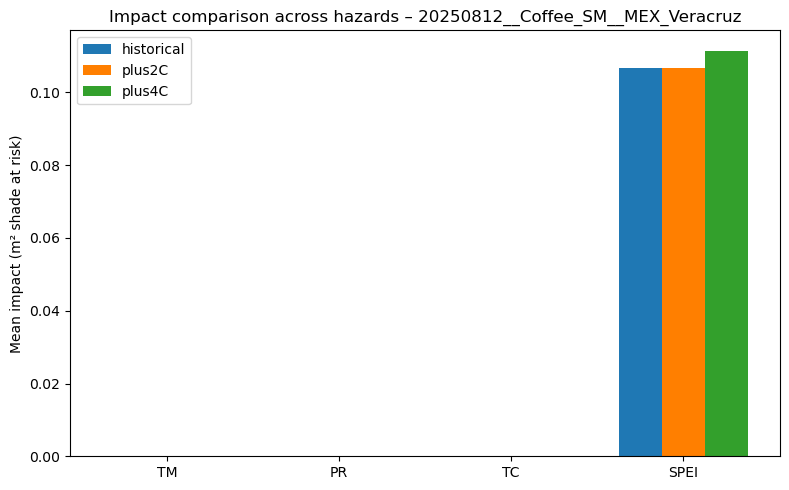

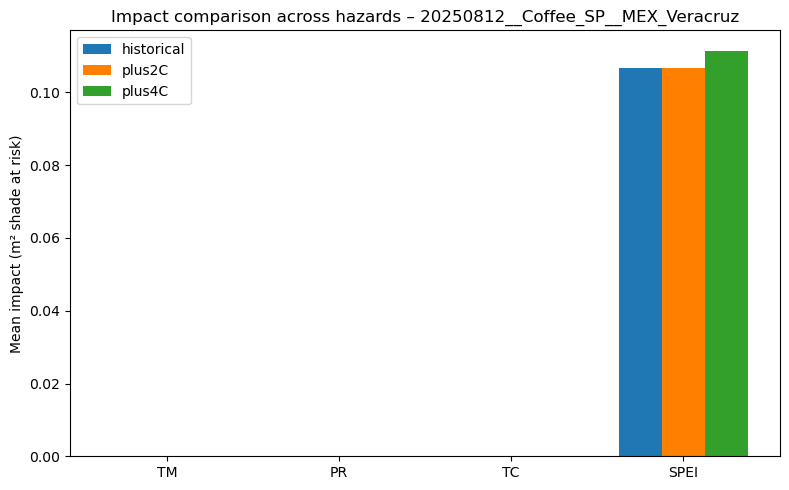

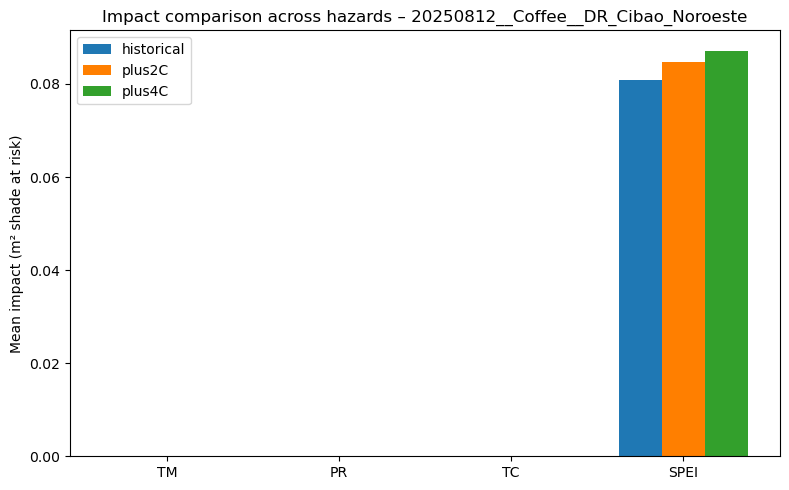

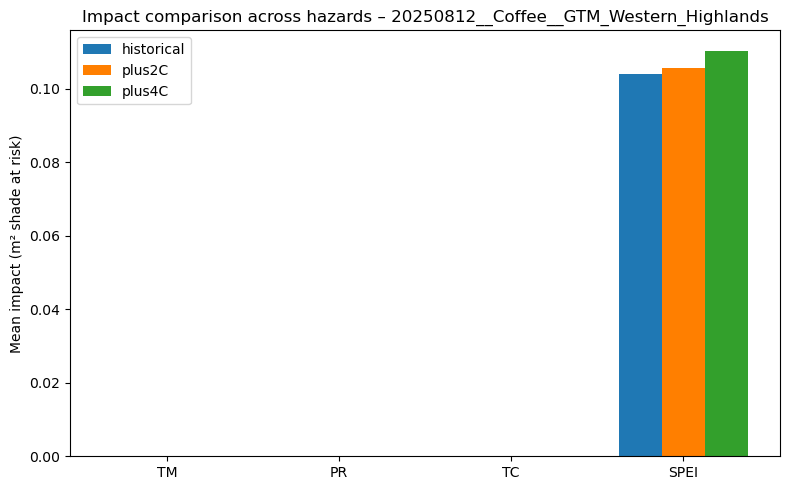

In [185]:
import matplotlib.pyplot as plt
import numpy as np

scenarios = ["historical", "plus2C", "plus4C"]
hazards = ["TM", "PR", "TC", "SPEI"]

scenario_colors = {
    "historical": "#1f78b4",
    "plus2C": "#ff7f00",
    "plus4C": "#33a02c"
}

for plot_name, scenario_dict in impact_results.items():
    fig, ax = plt.subplots(figsize=(8, 5))

    bar_width = 0.25
    x = np.arange(len(hazards))

    for i, scenario in enumerate(scenarios):
        values = []
        for haz in hazards:
            try:
                imp = scenario_dict[scenario][haz]
                mean_impact = imp.imp_mat.mean()  # aggregate across species & years
                values.append(mean_impact)
            except KeyError:
                values.append(0)

        ax.bar(x + i*bar_width, values, width=bar_width,
               label=scenario, color=scenario_colors[scenario])

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(hazards)
    ax.set_ylabel("Mean impact (m² shade at risk)")
    ax.set_title(f"Impact comparison across hazards – {plot_name}")
    ax.legend()
    plt.tight_layout()
    plt.show()


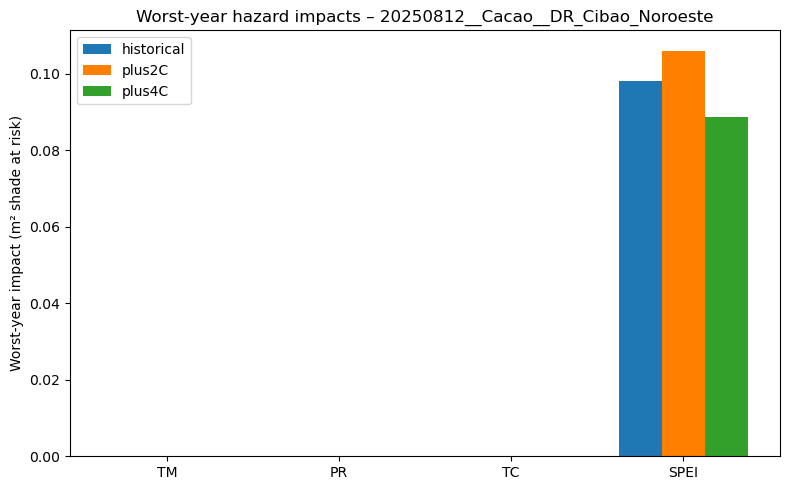

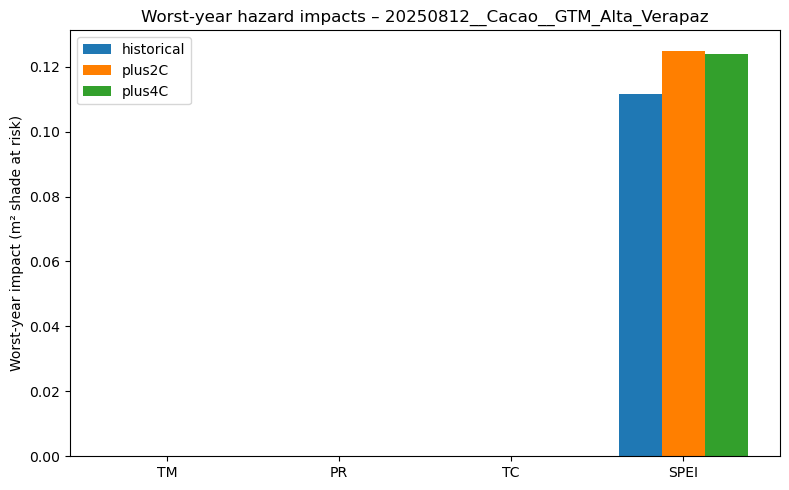

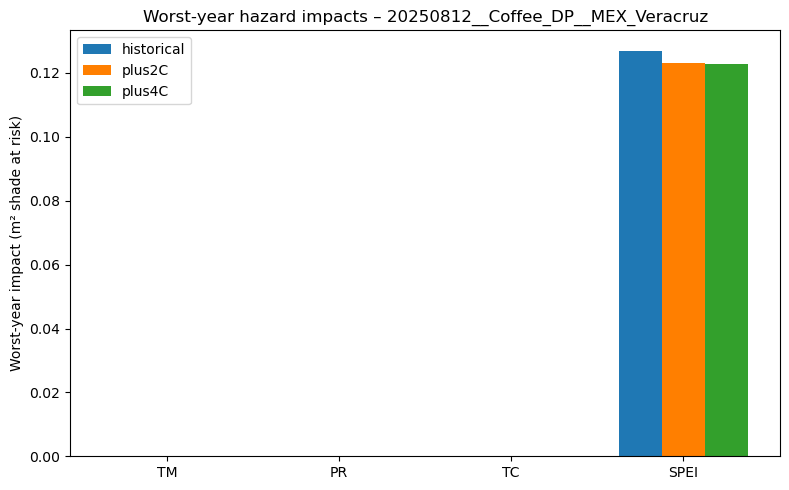

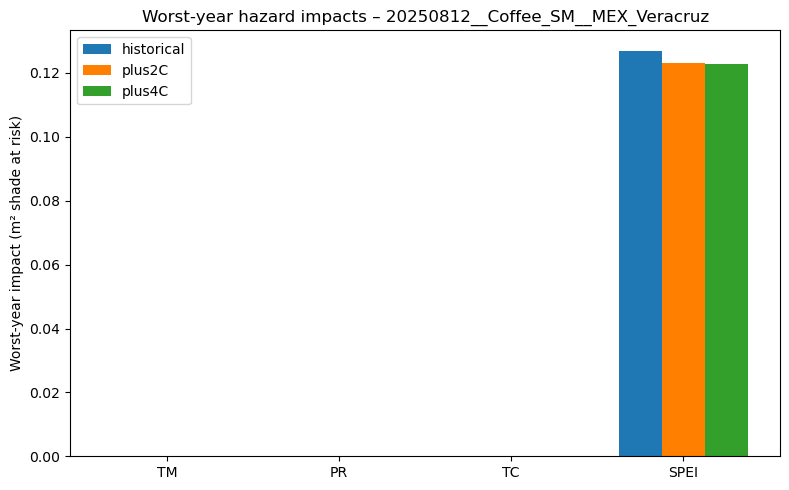

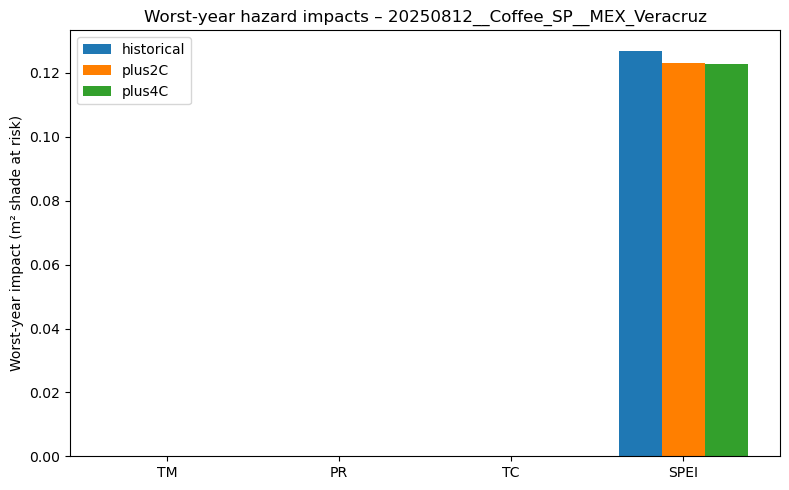

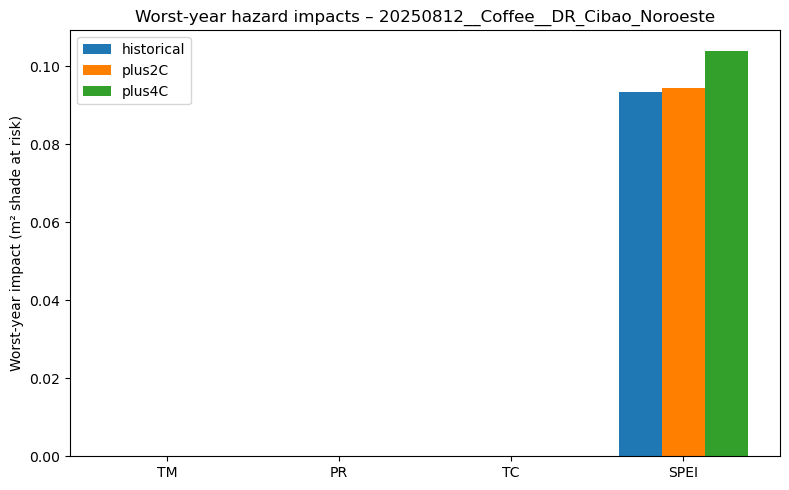

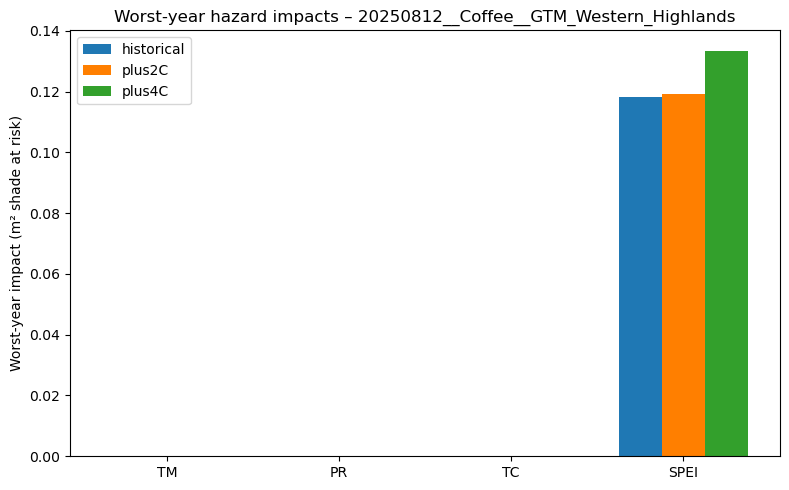

In [186]:
import matplotlib.pyplot as plt
import numpy as np

scenarios = ["historical", "plus2C", "plus4C"]
hazards = ["TM", "PR", "TC", "SPEI"]

scenario_colors = {
    "historical": "#1f78b4",
    "plus2C": "#ff7f00",
    "plus4C": "#33a02c"
}

for plot_name, scenario_dict in impact_results.items():
    fig, ax = plt.subplots(figsize=(8, 5))
    bar_width = 0.25
    x = np.arange(len(hazards))

    for i, scenario in enumerate(scenarios):
        values = []
        for haz in hazards:
            try:
                imp = scenario_dict[scenario][haz]
                # take the max across years of eai_exp
                worst_year = np.max(imp.eai_exp)
                values.append(worst_year)
            except KeyError:
                values.append(0)

        ax.bar(x + i*bar_width, values, width=bar_width,
               label=scenario, color=scenario_colors[scenario])

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(hazards)
    ax.set_ylabel("Worst-year impact (m² shade at risk)")
    ax.set_title(f"Worst-year hazard impacts – {plot_name}")
    ax.legend()
    plt.tight_layout()
    plt.show()
